## 图像卷积

### 互相关运算
卷积层是个错误的叫法，因为它所表达的运算其实是互相关运算（cross-correlation），⽽不是卷
积运算。在卷积层中，输⼊张量和核张量通过互相关运算产⽣输出张量。  
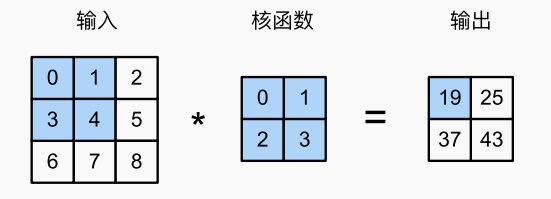  
⼆维互相关运算。阴影部分是第⼀个输出元素，以及⽤于计算输出的输⼊张量元素和核张量元素：0 × 0 + 1 × 1 + 3 × 2 + 4 × 3 = 19.

注意，输出⼤⼩略⼩于输⼊⼤⼩。这是因为卷积核的宽度和⾼度⼤于1，⽽卷积核只与图像中每个⼤⼩完全适
合的位置进⾏互相关运算。所以，输出⼤⼩等于输⼊⼤⼩nh × nw减去卷积核⼤⼩kh × kw，即：(nh − kh + 1) × (nw − kw + 1).

接下来，我们在corr2d函数中实现如上过程，该函数接受输⼊张量X和卷积核张量K，并返回输出张量Y。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

#输入张量X和卷积核张量K
def corr2d(X, K): #@save
    """计算⼆维互相关运算"""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum()
    return Y

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 卷积层
卷积层对输⼊和卷积核权重进⾏互相关运算，并在添加标量偏置之后产⽣输出。所以，卷积层中的两个被训
练的参数是卷积核权重和标量偏置。就像我们之前随机初始化全连接层⼀样，在训练基于卷积层的模型时，
我们也随机初始化卷积核权重。  

基于上⾯定义的corr2d函数实现⼆维卷积层。在__init__构造函数中，将weight和bias声明为两个模型参数。
前向传播函数调⽤corr2d函数并添加偏置。

In [ ]:
class Conv2D(nn.Module):

    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

⾼度和宽度分别为h和w的卷积核可以被称为h × w卷积或h × w卷积核。我们也将带有h × w卷积核的卷积层
称为h × w卷积层。

### 图像中目标的边缘检测
如下是卷积层的⼀个简单应⽤：通过找到像素变化的位置，来检测图像中不同颜⾊的边缘。⾸先，我们构造
⼀个6 × 8像素的⿊⽩图像。中间四列为⿊⾊（0），其余像素为⽩⾊（1）。

In [3]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

接下来，我们构造⼀个⾼度为1、宽度为2的卷积核K。当进⾏互相关运算时，如果⽔平相邻的两元素相同，则
输出为零，否则输出为⾮零。

In [5]:
K = torch.tensor([[1.0, -1.0]])
K

tensor([[ 1., -1.]])

对参数X（输⼊）和K（卷积核）执⾏互相关运算。如下所⽰，输出Y中的1代表从⽩⾊到⿊⾊的边
缘，-1代表从⿊⾊到⽩⾊的边缘，其他情况的输出为0。

In [6]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

现在我们将输⼊的⼆维图像转置，再进⾏如上的互相关运算。其输出如下，之前检测到的垂直边缘消失了。
不出所料，这个卷积核K只可以检测垂直边缘，⽆法检测⽔平边缘。

In [7]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 学习卷积核
如果只需寻找⿊⽩边缘，那么以上[1, -1]的边缘检测器⾜以。然⽽，当有了更复杂数值的卷积核，或者
连续的卷积层时，我们不可能⼿动设计滤波器。那么我们是否可以学习由X⽣成Y的卷积核呢？  

现在让我们看看是否可以通过仅查看“输⼊-输出”对来学习由X⽣成Y的卷积核。我们先构造⼀个卷积层，并
将其卷积核初始化为随机张量。接下来，在每次迭代中，我们⽐较Y与卷积层输出的平⽅误差，然后计算梯度
来更新卷积核。为了简单起⻅，我们在此使⽤内置的⼆维卷积层，并忽略偏置。

In [8]:
# 构造⼀个⼆维卷积层，它具有1个输出通道和形状为（1，2）的卷积核
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# 这个⼆维卷积层使⽤四维输⼊和输出格式（批量⼤⼩、通道、⾼度、宽度），
# 其中批量⼤⼩和通道数都为1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))
lr = 3e-2 # 学习率

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2 #损失函数
    conv2d.zero_grad() # 将参数梯度初始化为0
    l.sum().backward() #反向传播计算w和b，这里没有计算b
    # 迭代卷积核
    conv2d.weight.data[:] -= lr * conv2d.weight.grad #不断逼近w
    if (i + 1) % 2 == 0:
        print(f'epoch {i+1}, loss {l.sum():.3f}')

epoch 2, loss 1.163
epoch 4, loss 0.225
epoch 6, loss 0.050
epoch 8, loss 0.014
epoch 10, loss 0.004


In [9]:
# 在10次迭代之后，误差已经降到⾜够低。现在我们来看看我们所学的卷积核的权重张量。
conv2d.weight.data.reshape((1, 2))

tensor([[ 0.9886, -1.0008]])

### 相互关和卷积
为了得到正式的卷积运算输出，需要执⾏定义的严格卷积运算，⽽不是互相关运算。幸运的是，它们差别不⼤，只需⽔平和垂直翻转⼆维卷积核张量，然后对输⼊张量执⾏互相关运算。  
值得注意的是，由于卷积核是从数据中学习到的，因此⽆论这些层执⾏严格的卷积运算还是互相关运算，卷
积层的输出都不会受到影响。为了说明这⼀点，假设卷积层执⾏互相关运算并学习卷积核，该卷
积核在这⾥由矩阵K表⽰。

### 特征映射和感受野
输出的卷积层有时被称为特征映射（feature map），因为它可以被视为⼀个输
⼊映射到下⼀层的空间维度的转换器。在卷积神经⽹络中，对于某⼀层的任意元素x，其感受野（receptive
field）是指在前向传播期间可能影响x计算的所有元素（来⾃所有先前层）。

## 小结
* ⼆维卷积层的核⼼计算是⼆维互相关运算。最简单的形式是，对⼆维输⼊数据和卷积核执⾏互相关操作，然后添加⼀个偏置。
* 可以设计⼀个卷积核来检测图像的边缘。
* 可以从数据中学习卷积核的参数。
* 学习卷积核时，⽆论⽤严格卷积运算或互相关运算，卷积层的输出不会受太⼤影响。
* 当需要检测输⼊特征中更⼴区域时，可以构建⼀个更深的卷积⽹络。